In [ ]:
# THIS NOTEBOOK IS FOR ANALYSIS ONLY, THAT IS WHY IT DOES NOT FOLLOW THE USUAL LAYOUT (GLOBALS, UTILS, ETC.)

In [1]:
# Analyze current data distribution in ccpd_green folder
import os
import shutil
import random
from pathlib import Path

# Set paths
ccpd_green_path = Path("./ccpd_green")
train_path = ccpd_green_path / "train"
val_path = ccpd_green_path / "val" 
test_path = ccpd_green_path / "test"

# Count current files
train_files = list(train_path.glob("*"))
val_files = list(val_path.glob("*"))
test_files = list(test_path.glob("*"))

print("Current distribution:")
print(f"Train: {len(train_files)} files")
print(f"Val: {len(val_files)} files")
print(f"Test: {len(test_files)} files")
print(f"Total: {len(train_files) + len(val_files) + len(test_files)} files")

# Calculate percentages
total_files = len(train_files) + len(val_files) + len(test_files)
print(f"\nCurrent percentages:")
print(f"Train: {len(train_files)/total_files*100:.1f}%")
print(f"Val: {len(val_files)/total_files*100:.1f}%")
print(f"Test: {len(test_files)/total_files*100:.1f}%")

Current distribution:
Train: 5769 files
Val: 1001 files
Test: 5006 files
Total: 11776 files

Current percentages:
Train: 49.0%
Val: 8.5%
Test: 42.5%


In [2]:
# Rebalance data splits - Target: 70% train, 15% val, 15% test
import numpy as np

# Target percentages
train_target = 0.70
val_target = 0.15
test_target = 0.15

# Calculate target numbers
target_train = int(total_files * train_target)
target_val = int(total_files * val_target)
target_test = total_files - target_train - target_val  # Ensure we use all files

print(f"\nTarget distribution:")
print(f"Train: {target_train} files ({target_train/total_files*100:.1f}%)")
print(f"Val: {target_val} files ({target_val/total_files*100:.1f}%)")
print(f"Test: {target_test} files ({target_test/total_files*100:.1f}%)")

# Collect all files and shuffle them
all_files = train_files + val_files + test_files
random.seed(42)  # For reproducibility
random.shuffle(all_files)

print(f"\nFiles to move:")
print(f"Need to move to train: {target_train - len(train_files)}")
print(f"Need to move to val: {target_val - len(val_files)}")
print(f"Need to move to test: {target_test - len(test_files)}")

# Create backup of current structure first
print("\nReady to rebalance. Run the next cell to execute the rebalancing.")


Target distribution:
Train: 8243 files (70.0%)
Val: 1766 files (15.0%)
Test: 1767 files (15.0%)

Files to move:
Need to move to train: 2474
Need to move to val: 765
Need to move to test: -3239

Ready to rebalance. Run the next cell to execute the rebalancing.


In [ ]:
# Execute rebalancing - CAREFUL: This will move files!
from tqdm import tqdm


def move_files_to_target_split():
    """
    Rebalance the files across train/val/test folders
    """
    # Create temporary folder to avoid conflicts
    temp_path = ccpd_green_path / "temp_rebalance"
    temp_path.mkdir(exist_ok=True)
    
    print("Step 1: Moving all files to temp")
    all_current_files = []
    
    # Move all files to temp folder
    for folder in [train_path, val_path, test_path]:
        files = list(folder.glob("*"))
        for file in tqdm(files, desc=f"Moving from {folder.name}"): #tqdm for progress bar
            if file.is_file():
                dest = temp_path / file.name
                shutil.move(str(file), str(dest))
                all_current_files.append(dest)
    
    # Shuffle and redistribute
    random.shuffle(all_current_files)
    
    print(f"\nStep 2: Redistributing {len(all_current_files)} files...")
    
    # Split into new groups
    train_end = target_train
    val_end = target_train + target_val
    
    new_train_files = all_current_files[:train_end]
    new_val_files = all_current_files[train_end:val_end]
    new_test_files = all_current_files[val_end:]
    
    # Move to final destinations
    for file in tqdm(new_train_files, desc="Moving to train"):
        shutil.move(str(file), str(train_path / file.name))
    
    for file in tqdm(new_val_files, desc="Moving to val"):
        shutil.move(str(file), str(val_path / file.name))
    
    for file in tqdm(new_test_files, desc="Moving to test"):
        shutil.move(str(file), str(test_path / file.name))
    
    # Clean up temp folder
    temp_path.rmdir()
    
    print("\nRebalancing completed!")
    
    # Verify new distribution
    new_train = len(list(train_path.glob("*")))
    new_val = len(list(val_path.glob("*")))
    new_test = len(list(test_path.glob("*")))
    
    print(f"\nNew distribution:")
    print(f"Train: {new_train} files ({new_train/total_files*100:.1f}%)")
    print(f"Val: {new_val} files ({new_val/total_files*100:.1f}%)")
    print(f"Test: {new_test} files ({new_test/total_files*100:.1f}%)")






#call function
move_files_to_target_split()


Step 1: Moving all files to temporary folder...


Moving from test: 100%|██████████| 5006/5006 [00:03<00:00, 1488.73it/s]



Step 2: Redistributing 11776 files...


Moving to test: 100%|██████████| 1767/1767 [00:00<00:00, 2808.68it/s]




Rebalancing completed!

New distribution:
Train: 8243 files (70.0%)
Val: 1766 files (15.0%)
Test: 1767 files (15.0%)
IMPORTANT: Uncomment the last line and run this cell to execute the rebalancing.
This will permanently move your files. Make sure you have a backup if needed!


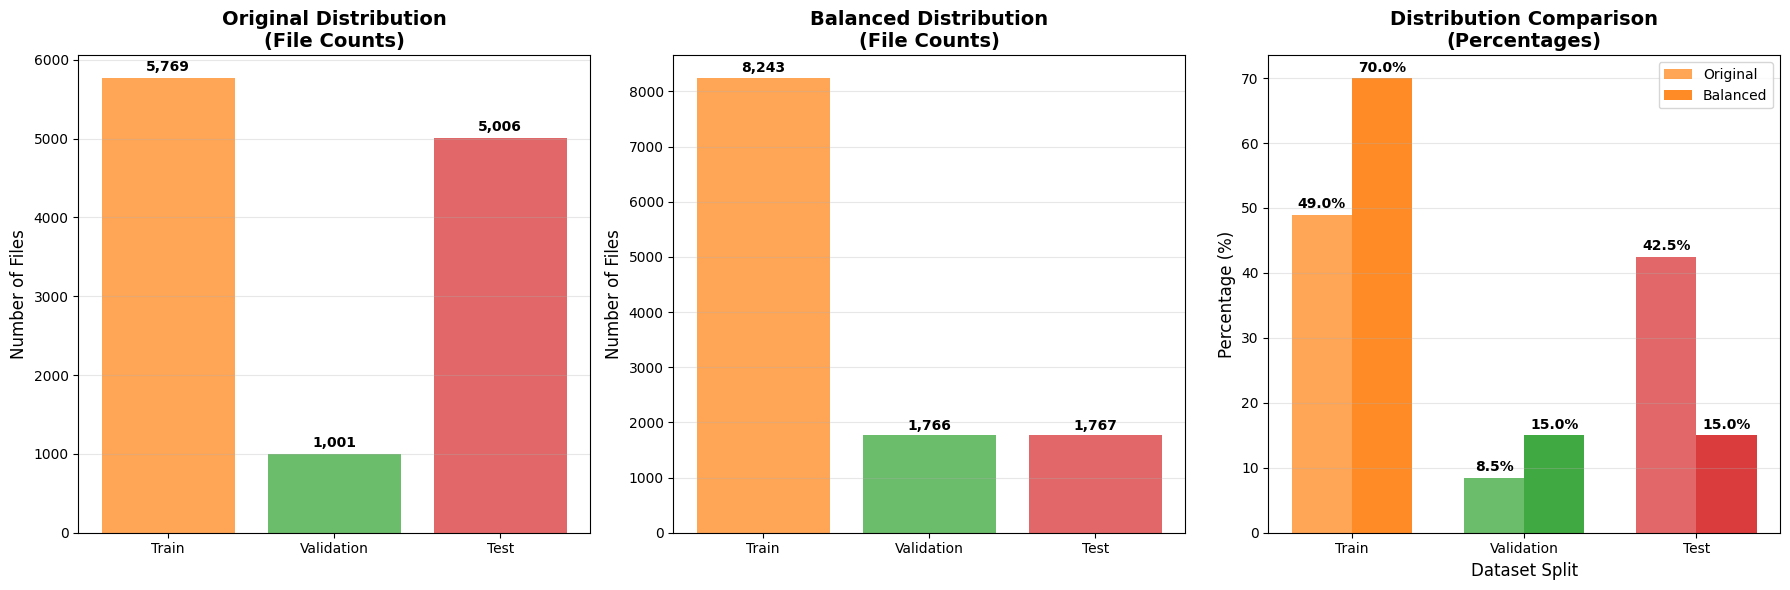

DATASET DISTRIBUTION SUMMARY
Total files: 11,776

ORIGINAL DISTRIBUTION:
  Train       : 5,769 files (49.0%)
  Validation  : 1,001 files (8.5%)
  Test        : 5,006 files (42.5%)

BALANCED DISTRIBUTION:
  Train       : 8,243 files (70.0%)
  Validation  : 1,766 files (15.0%)
  Test        : 1,767 files (15.0%)

CHANGES NEEDED:
  Train       : +2,474 files
  Validation  : +765 files
  Test        : -3,239 files


In [4]:
# Create histograms to compare old vs balanced dataset distributions
import matplotlib.pyplot as plt
import numpy as np

def plot_distribution_comparison():
    """
    Plot histograms comparing the old and new data distributions
    """
    # Original distribution (from previous analysis)
    original_train = len(train_files)
    original_val = len(val_files) 
    original_test = len(test_files)
    
    # Target distribution (calculated)
    target_train_count = target_train
    target_val_count = target_val
    target_test_count = target_test
    
    # Data for plotting
    categories = ['Train', 'Validation', 'Test']
    original_counts = [original_train, original_val, original_test]
    target_counts = [target_train_count, target_val_count, target_test_count]
    
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot 1: Original Distribution (Counts)
    bars1 = ax1.bar(categories, original_counts, color=['#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
    ax1.set_title('Original Distribution\n(File Counts)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Files', fontsize=12)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars1, original_counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 50,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Target Distribution (Counts)
    bars2 = ax2.bar(categories, target_counts, color=['#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
    ax2.set_title('Balanced Distribution\n(File Counts)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Files', fontsize=12)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars2, target_counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 50,
                f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: Percentage Comparison
    original_percentages = [count/total_files*100 for count in original_counts]
    target_percentages = [count/total_files*100 for count in target_counts]
    
    x = np.arange(len(categories))
    width = 0.35
    
    bars3a = ax3.bar(x - width/2, original_percentages, width, label='Original', 
                     color=['#ff7f0e', '#2ca02c', '#d62728'], alpha=0.7)
    bars3b = ax3.bar(x + width/2, target_percentages, width, label='Balanced',
                     color=['#ff7f0e', '#2ca02c', '#d62728'], alpha=0.9)
    
    ax3.set_title('Distribution Comparison\n(Percentages)', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Percentage (%)', fontsize=12)
    ax3.set_xlabel('Dataset Split', fontsize=12)
    ax3.set_xticks(x)
    ax3.set_xticklabels(categories)
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    for bars, percentages in [(bars3a, original_percentages), (bars3b, target_percentages)]:
        for bar, pct in zip(bars, percentages):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("="*60)
    print("DATASET DISTRIBUTION SUMMARY")
    print("="*60)
    print(f"Total files: {total_files:,}")
    print()
    
    print("ORIGINAL DISTRIBUTION:")
    for cat, count, pct in zip(categories, original_counts, original_percentages):
        print(f"  {cat:12}: {count:,} files ({pct:.1f}%)")
    
    print("\nBALANCED DISTRIBUTION:")
    for cat, count, pct in zip(categories, target_counts, target_percentages):
        print(f"  {cat:12}: {count:,} files ({pct:.1f}%)")
    
    print("\nCHANGES NEEDED:")
    for cat, orig, target in zip(categories, original_counts, target_counts):
        change = target - orig
        print(f"  {cat:12}: {change:+,} files")

# Run the visualization
plot_distribution_comparison()

In [7]:
from imports import *
from utils import *
from global_vars import *


dataset = CarPlateDataset(img_dir = "./ccpd_green/train", transform=None, cropped= False)

# Data

A sample image name is "04-90_267-158&448_542&553-541&553_162&551_158&448_542&450-0_1_3_24_27_33_30_24-99-116.jpg".
Each name can be splited by "-" into seven fields. Those fields are explained as follows.

1) Area: Area ratio of license plate area to the entire picture area.

2) Tilt degree: Horizontal tilt degree and vertical tilt degree.

3) Bounding box coordinates: The coordinates of the left-up and the right-bottom vertices.

4) Four vertices locations: The exact (x, y) coordinates of the four vertices of LP in the whole image. These coordinates start from the right-bottom vertex.

5) License plate number: Each image in CCPD has only one LP. Each LP number is comprised of a Chinese character, a letter, and five letters or numbers. A valid Chinese license plate consists of seven characters:

       - province (1 character),
       - alphabets (1 character),
       - alphabets+digits (6 characters).

"0_0_22_27_27_33_16" is the index of each character. These three arrays are defined as follows. The last character of each array is letter O rather than a digit 0. We use O as a sign of "no character" because there is no O in Chinese license plate characters.

provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]


alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']


ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']


6) Brightness: The brightness of the license plate region.

7) Blurriness: The Blurriness of the license plate region.

In [13]:
image = Image.open("./ccpd_green/test/02-84_90-245&479_437&584-437&551_245&584_245&503_429&479-0_0_3_24_33_26_33_26-103-32.jpg")
string = "437&551_245&584_245&503_429&479"
vertexes = string.split("_")

points = [tuple(map(int, p.split("&"))) for p in vertexes]

xs = [x for x, y in points]
ys = [y for x, y in points]

left   = min(xs)
right  = max(xs)
upper  = min(ys)
lower  = max(ys)

cropped = image.crop((left, upper, right, lower))
cropped.show()

In [2]:
ex = "04-90_267-158&448_542&553-541&553_162&551_158&448_542&450-0_1_3_24_27_33_30_24-99-116"
camps = ex.split("-")
camps

['04',
 '90_267',
 '158&448_542&553',
 '541&553_162&551_158&448_542&450',
 '0_1_3_24_27_33_30_24',
 '99',
 '116']

In [18]:
img_path = "./ccpd_green/test/02-84_90-245&479_437&584-437&551_245&584_245&503_429&479-0_0_3_24_33_26_33_26-103-32.jpg"
filename = "02-84_90-245&479_437&584-437&551_245&584_245&503_429&479-0_0_3_24_33_26_33_26-103-32.jpg"

# 1. Load image and get size
image = Image.open(img_path)
img_w, img_h = image.size

# 2. Parse annotation string
vertexes = filename.split("-")[3]
points = [ tuple(map(int, p.split("&"))) for p in vertexes.split("_")]
points

[(437, 551), (245, 584), (245, 503), (429, 479)]